In [8]:
from ete3 import EvolTree
from ete3.treeview.layouts import evol_clean_layout
from ete3 import NCBITaxa
import matplotlib.pyplot as plt
import os
import shutil
ncbi = NCBITaxa()

def file_exists(filename):
    current_directory = os.getcwd()
    if os.path.exists(filename):
        print(f"The file {filename} exists in the current working directory {current_directory}.")
    else:
        print(f"The file {filename} does not exist in the current working directory {current_directory}.")

def organize_your_life(input_alignment):
    # get the full path of the input file
    full_input_file_path = os.path.abspath(input_alignment)
    full_input_newick_path = full_input_file_path + '.nwk'
    
    directory, alignment = os.path.split(full_input_file_path)
    directory, newick = os.path.split(full_input_newick_path)

    path = os.path.join(directory, f"{alignment}.evolTree")
    os.makedirs(path, exist_ok=True)
    
    '''
    #still learning
    print(f"directory: {directory}")
    print(f"new_directory: {path}")
    print(f"input_alignment: {input_alignment}")
    print(f"input_file_path: {full_input_file_path}")
    print(f"input_alignmentname: {input_alignmentname}")
    print(f"input_newick: {input_newick}")
    print(f"input_newickname: {input_newickname}")
    '''
    
    # copy input files the new directory
    shutil.copy(full_input_file_path, path)
    shutil.copy(full_input_newick_path, path)

    # move to the new directory
    os.chdir(path)
    print(f"EvolTree running in new folder: {path}")
    
    # load the tree
    tree = EvolTree(newick = full_input_newick_path, format=1)
    # associate alignment to tree
    tree.link_to_alignment(input_alignment)
    tree.workdir = path # set working directory where models will be saved
    alnPrefix = alignment # might need this in the future, like for saving files?
    return tree, alnPrefix
    
# Get species name from TaxID
def get_species_name(taxid):
    try:
        lineage = ncbi.get_lineage(taxid)
        names = ncbi.get_taxid_translator(lineage)
        species_name = names[taxid]
        return species_name
    except:
        return f"Unknown_species_{taxid}"

tree, alnPrefix = organize_your_life('/Users/jra/Dropbox/ciliates/P0460249_riboprotein/P0460249_riboprotein_ohnologs.fa.aligned.trimal.automated1.cds')

#print(alignment)
#print(newick)
#print(os.getcwd())
print(tree)
#print(prefix)

EvolTree running in new folder: /Users/jra/Dropbox/ciliates/P0460249_riboprotein/P0460249_riboprotein_ohnologs.fa.aligned.trimal.automated1.cds.evolTree

      /-5888.PTET_51_T0460249
   /-|
  |   \-5888.PTET_51_T1750015
--|
  |--5888.PTET_51_T0360256
  |
   \-5888.PTET_51_T0210034


5888.PTET_51_T0460249	Paramecium tetraurelia	0.1388
5888.PTET_51_T1750015	Paramecium tetraurelia	0.1398
5888.PTET_51_T0360256	Paramecium tetraurelia	0.7080
5888.PTET_51_T0210034	Paramecium tetraurelia	0.0000
Ds values have been written to P0460249_riboprotein_ohnologs.fa.aligned.trimal.automated1.cds.ref.dS.txt


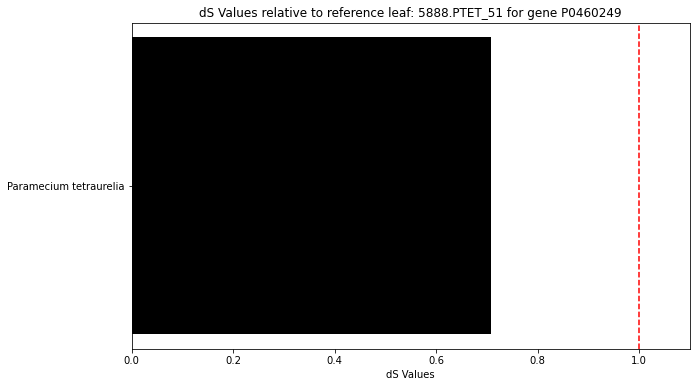

In [9]:
# calculate dS values relative to a reference leaf
# hard-code Paramecium tetraurelia because it is Queen

def calculate_dS(reference):
    partial_leaf_name = reference
    output_txt = alnPrefix + '.ref.dS.txt'
    output_fig  = alnPrefix + '.ref.dS.pdf'
    # Initialize variables to store the reference leaf and its full name
    reference_leaf = None
    reference_leaf_name = None

    # Search for the leaf with a name that starts with the specified partial name
    for leaf in tree:
        if leaf.name.startswith(partial_leaf_name):
            reference_leaf = leaf
            reference_leaf_name = leaf.name

    if reference_leaf:
        # Calculate dS values for leaves relative to the reference leaf
        dS_values = {}

        for leaf in tree:
            # Extract TaxID from the leaf name
            taxid = int(leaf.name.split('.')[0])

            # Get the scientific name associated with the TaxID
            species_name = ncbi.get_taxid_translator([taxid]).get(taxid, leaf.name)

            # Calculate the dS value for the leaf relative to the reference leaf
            dS = reference_leaf.get_distance(leaf)
            dS_values[leaf.name] = {'Species': species_name, 'dS': dS}

        with open(output_txt, "w") as f:
            f.write('#gene\tspecies\tdS\n')
            for leaf_name, data in dS_values.items():
                print(f"{leaf_name}\t{data['Species']}\t{data['dS']:.4f}")
                f.write(f"{leaf_name}\t{data['Species']}\t{data['dS']:.4f}\n")
            print(f"Ds values have been written to {output_txt}")



        # Create a bar chart
        geneName = str(alnPrefix.split("_")[0])
        leaf_names = list(dS_values.keys())
        species_names = [data['Species'] for data in dS_values.values()]
        dS_values_list = [data['dS'] for data in dS_values.values()]

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.barh(species_names, dS_values_list, color='black')
        ax.set_xlabel('dS Values')
        ax.set_title('dS Values relative to reference leaf: ' + partial_leaf_name + ' for gene ' + geneName)

        # Set x-axis limit to 1.1 if dS values are less than 1.1
        max_dS = max(dS_values_list)
        if max_dS < 1.1:
            ax.set_xlim(0, 1.1)

        # Add a red dotted line at x=1
        ax.axvline(x=1, color='red', linestyle='--')

        # Save the plot
        plt.savefig(output_fig)
        plt.show()

    else:
        print(f"No leaf found in the tree with a name starting with '{partial_leaf_name}'.")

calculate_dS('5888.PTET_51')

In [10]:
# run the evolutionary models (longest step)
# intelligently checking whether a model exists was a massive waste of time because ete3 is a fucking fuck and won't "find" the models after it is relaunched

#def folder_exists(folderPath):
#    return os.path.exists(folderPath) and os.path.isdir(folderPath)

#model = ["M1", "M2", "M7", "M8", "M0", "fb"]
models = ['M1', 'M2', 'M7', 'M8']

#for model in models:
#    if not folder_exists(model):
#        tree.run_model(model)
#    else:
#        print(f"The model {model} exists. Skipping")
for model in models:
    print(model)
    tree.run_model(model)
        

In [11]:
def get_pvals(alt, neg):

    altModel = tree.get_evol_model(alt)
    pval = tree.get_most_likely(alt, neg)
    print(pval)
    output_file = alnPrefix + '.pvals.txt'
    with open(output_file, "a") as output:
        output.write('altModel\tnegModel\tpval\n')
        output.write(alt + '\t' + neg  +  '\t' + str(pval) + '\n')

    if pval < 0.05:
        output_file2 = alnPrefix + '.sigAAs.txt'
        with open(output_file2, "a") as output2:
            output2.write('alt_model\tnegmodel\taa\tposition\tprobability\n')
            print(f'{alt} model wins.')
            for s in range(len(altModel.sites['BEB']['aa'])):
                    if altModel.sites['BEB']['p10'][s] > 0.95:
                        pos_acid = altModel.sites['BEB']['aa'][s]
                        pos_site = str(s)
                        pos_prob = str(altModel.sites['BEB']['p10'][s])
                        pos_omega = str(altModel.sites['BEB']['w'][s])
                        p0 = altModel.sites['BEB']['p0'][s]
                        p1 = altModel.sites['BEB']['p1'][s]
                        p2 = altModel.sites['BEB']['p2'][s]
                        p3 = altModel.sites['BEB']['p3'][s]
                        p4 = altModel.sites['BEB']['p4'][s]
                        p5 = altModel.sites['BEB']['p5'][s]
                        p6 = altModel.sites['BEB']['p6'][s]
                        p7 = altModel.sites['BEB']['p7'][s]
                        p8 = altModel.sites['BEB']['p8'][s]
                        p9 = altModel.sites['BEB']['p9'][s]
                        p10 = altModel.sites['BEB']['p10'][s]
                        pv = altModel.sites['BEB']['pv'][s]
                        w = altModel.sites['BEB']['w'][s]
                        se = altModel.sites['BEB']['se'][s]
                        
                        #print(s, p0, p1, p2, p3, p4, p5, p6, p7, p8, "p9:", p9, "p10:", p10, "pv:", pv, w, se)
                        
                        output_line2 = alt + '\t' + neg + '\t' + pos_acid + '\t' + pos_site + '\t' + pos_prob + '\t' + pos_omega + '\t' + '\n'
                        print(output_line2)
                        #print(altModel.sites['BEB'].keys())
                        output2.write(output_line2)
                        #print(altModel.sites['BEB']['p8'][s])
    else:
        print(f'{neg} model is not rejected')

        
get_pvals('M8', 'M7')

0.008258931980424156
M8 model wins.


In [12]:
# TABARNAK WHY THE FUCK CANT THIS STUPID FUCK ETE3 FIND THE FUCKING MODELS IN THE FUCKING WORKING DIRECTORY I FUCKING SPECIFIED

output_models = alnPrefix + '.models'
with open(output_models, "w") as output:
    for model in models:
        print(model)
        get_model = tree.get_evol_model(model)
        print(get_model)
        output.write(str(get_model)+'\n')

M1
 Evolutionary Model M1:
        log likelihood       : -2665.441654
        number of parameters : 8
        sites inference      : NEB
        sites classes        : 
        proportions : p0=0.96733   p1=0.03267   
        w           : w0=0.04988   w1=1.0       
        branches             : 
        mark:     , omega: None      , node_ids: 5   , name: Inner2
        mark:     , omega: 0.0809    , node_ids: 6   , name: Inner1
        mark:     , omega: 0.0809    , node_ids: 2   , name: 5888.PTET_51_T0360256
        mark:     , omega: 0.0809    , node_ids: 1   , name: 5888.PTET_51_T0210034
        mark:     , omega: 0.0809    , node_ids: 3   , name: 5888.PTET_51_T0460249
        mark:     , omega: 0.0809    , node_ids: 4   , name: 5888.PTET_51_T1750015
        
M2
 Evolutionary Model M2:
        log likelihood       : -2664.867291
        number of parameters : 10
        sites inference      : BEB, NEB
        sites classes        : 
        proportions : p0=0.97733   p1=0.0    

M1 model is not rejected
M8 model wins.
positively selected site 48 at position: 48 with probability: 0.12965
positively selected site 50 at position: 50 with probability: 0.10712
positively selected site 51 at position: 51 with probability: 0.09468
positively selected site 76 at position: 76 with probability: 0.12677
positively selected site 82 at position: 82 with probability: 0.06181
positively selected site 101 at position: 101 with probability: 0.12116
positively selected site 104 at position: 104 with probability: 0.09389
positively selected site 128 at position: 128 with probability: 0.05086
positively selected site 181 at position: 181 with probability: 0.13579
positively selected site 231 at position: 231 with probability: 0.10455
positively selected site 238 at position: 238 with probability: 0.12402
positively selected site 253 at position: 253 with probability: 0.06887
positively selected site 273 at position: 273 with probability: 0.05395
positively selected site 274 at po

In [13]:
def evol_graphs(alt, neg, suffix):
    
    # Change the colours
    col_line = {'NS' : '#000000', 
           'RX' : '#000000', 'RX+': '#000000', 
           'CN' : '#000000', 'CN+': '#000000', 
           'PS' : '#000000', 'PS+': '#000000'}
    col_bar = {'NS' : '#BCBCBC', 
           'RX' : '#5D63AB', 'RX+': '#5D63AB', 
           'CN' : '#659A62', 'CN+': '#659A62', 
           'PS' : '#F4C95D', 'PS+': '#F4C95D'}

    # Print the first tree without naming branches
    alt_model = tree.get_evol_model(alt)
    neg_model = tree.get_evol_model(neg)

    alt_model.set_histface(up=True, colors=col_line, errors=True, kind='curve', ylim=[0,20], hlines = [1], hlines_col=['black'])
    tree.render(alnPrefix +  '.' + alt + suffix + '.line.pdf', histfaces=[alt])

    alt_model.set_histface(up=True, colors=col_bar, errors=True, kind='stick', ylim=[0,4], hlines = [1], hlines_col=['black'])
    tree.render(alnPrefix +  '.' + alt + suffix + '.bar.pdf', histfaces=[alt])

def modify_leaf_names_reroot():
    # Modify the tree leaf names
    # ONLY DO THIS AS THE LAST STEP
    for leaf in tree.iter_leaves():
        taxid = int(leaf.name.split('.')[0])
        species_name = get_species_name(taxid)
        leaf.name = species_name.split(' ')[1]
        
    preference_dictionary = {'tet':1, 
                         'qua':2, 'pen':2, 'pri':2, 'nov':2, 'dod':2, 'oct':2, 'sex':2, 'son':2, 'tre': 2,
                         'cau':3}
    root_point = tree.get_farthest_oldest_leaf(preference_dictionary)
    tree.set_outgroup(root_point)

    

    


In [14]:

evol_graphs('M2', 'M1', '')
evol_graphs('M8', 'M7', '')
modify_leaf_names()
evol_graphs('M2', 'M1', '_sp')
evol_graphs('M8', 'M7', '_sp')

NameError: name 'modify_leaf_names' is not defined

In [72]:
tree, alnPrefix = organize_your_life('/Users/jra/Dropbox/ciliates/P0460249_riboprotein/P0460249_riboprotein.fa.tblastn.fa.trimal.automated1.extract')
print(tree)
modify_leaf_names_reroot()

print(tree)

EvolTree running in new folder: /Users/jra/Dropbox/ciliates/P0460249_riboprotein/P0460249_riboprotein.fa.tblastn.fa.trimal.automated1.extract.evolTree

      /-224956.PQUADEC_NiA_T00270028
     |
     |      /-43138.PPENT_87_T0670067
   /-|   /-|
  |  |  |  |   /-5886.PPRIM_AZ9_T0580068
  |  |  |   \-|
  |   \-|      \-5886.PPRIM_Ir42_T15418
  |     |
  |     |   /-219701.PNOV_TE_T00080084
  |     |  |
  |      \-|   /-304694.PDODEC_274_T01140047
  |        |  |
  |         \-|      /-5888.PTET_51_T0460249
  |           |   /-|
--|           |  |   \-412030.PTET_42_T00015928001
  |            \-|
  |              |   /-43137.POCT_138_T0740045
  |               \-|
  |                  \-43137.POCT_K8_T71800002770320265
  |
  |   /-5885.PCAU_43c3d_T00080186
  |--|
  |  |   /-65128.PSEX_AZ84_T15940
  |   \-|
  |      \-65129.PSON_ATCC_T0490080
  |
   \-65130.PTRED_209_T71800001293390218

   /-caudatum
  |
  |      /-sexaurelia
  |   /-|
  |  |   \-sonneborni
--|  |
  |  |      /-quadecau

In [31]:

tree.run_model('fb')
fb_results = tree.get_evol_model('fb')
print(fb_results)



 Evolutionary Model fb:
        log likelihood       : -2669.541875
        number of parameters : 11
        sites inference      : None
        sites classes        : None
        branches             : 
        mark: #0  , omega: None      , node_ids: 5   , name: Inner2
        mark: #1  , omega: 0.0497    , node_ids: 6   , name: Inner1
        mark: #2  , omega: 0.5455    , node_ids: 2   , name: 5888.PTET_51_T0360256
        mark: #3  , omega: 507.2739  , node_ids: 1   , name: 5888.PTET_51_T0210034
        mark: #4  , omega: 0.0336    , node_ids: 3   , name: 5888.PTET_51_T0460249
        mark: #5  , omega: 0.0956    , node_ids: 4   , name: 5888.PTET_51_T1750015
        
None


/Users/jra/miniconda3/envs/ete3/lib/python3.6/site-packages/ete3/evol/evoltree.py:459: UserWarning: Model  Evolutionary Model fb:
        log likelihood       : -2669.541875
        number of parameters : 11
        sites inference      : None
        sites classes        : None
        branches             : 
        mark: #0  , omega: None      , node_ids: 5   , name: Inner2
        mark: #1  , omega: 0.0497    , node_ids: 6   , name: Inner1
        mark: #2  , omega: 0.5455    , node_ids: 2   , name: 5888.PTET_51_T0360256
        mark: #3  , omega: 507.2739  , node_ids: 1   , name: 5888.PTET_51_T0210034
        mark: #4  , omega: 0.0336    , node_ids: 3   , name: 5888.PTET_51_T0460249
        mark: #5  , omega: 0.0956    , node_ids: 4   , name: 5888.PTET_51_T1750015
         not found.
  warn("Model %s not found." % (modelname))


In [ ]:
# https://python.hotexamples.com/examples/ete3/EvolTree/run_model/python-evoltree-run_model-method-examples.html


from ete3 import TreeStyle
from ete3 import EvolTree
from ete3 import faces

tree = EvolTree("data/S_example/measuring_S_tree.nw")
tree.link_to_alignment('data/S_example/alignment_S_measuring_evol.fasta')

print(tree)

print('\n Running free-ratio model with calculation of ancestral sequences...')

tree.run_model('fb_anc')
#tree.link_to_evol_model('/tmp/ete3-codeml/fb_anc/out', 'fb_anc')

I = TreeStyle()
I.force_topology = False
I.draw_aligned_faces_as_table = True
I.draw_guiding_lines = True
I.guiding_lines_type = 2
I.guiding_lines_color = "#CCCCCC"
for n in sorted(tree.get_descendants() + [tree], key=lambda x: x.node_id):
    if n.is_leaf(): continue
    anc_face = faces.SequenceFace(n.sequence, 'aa', fsize=10, bg_colors={})
    I.aligned_foot.add_face(anc_face, 1)
    I.aligned_foot.add_face(
        faces.TextFace('node_id: #%d ' % (n.node_id), fsize=8), 0)
print('display result of bs_anc model, with ancestral amino acid sequences.')